Importing Libs and installing tensorflow

In [1]:
# may be needed to install some libraries such as tensorflow and keras
# %pip install tensorflow
# %pip install pydot
# %pip install pydot_ng
# %pip install graphviz

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, random
import CustomFunctions # custom our functions
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, LSTM, Reshape, Add, Flatten,Dense,Dropout,BatchNormalization, Activation,GlobalAveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from keras.optimizers import Adam,RMSprop,SGD, Adamax
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from keras import layers
import cv2

Load Data

Our dataset contains 28709 *train* images and 7178 *test* images.

The goal of this dataset is to identify sentiment based on a person face in order to (Melhorar não sei o que em recursos humanos)

That said the dataset contains images of people faces and 7 "class" of sentiments are available

* Angry
* Disgust
* Fear
* Happy 
* Neutral
* Sad
* Surprise

In [4]:
train_dir = "../../Data/AAUT2IA/train" #passing the path with training images
test_dir = "../../Data/AAUT2IA/test"   #passing the path with testing images

img_size = 48 #original size of the image

Emotions, train_dir_file_count = CustomFunctions.dirInfo(train_dir)

print("This dataset contains on \"" + train_dir + "\" " , train_dir_file_count, " in total")
print(Emotions, "\n\n")

_, test_dir_file_count = CustomFunctions.dirInfo(test_dir)

print("This dataset contains on \"" + test_dir + "\" " , test_dir_file_count, " in total")
print(_)

This dataset contains on "../../Data/AAUT2IA/train"  28709  in total
{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171} 


This dataset contains on "../../Data/AAUT2IA/test"  7178  in total
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


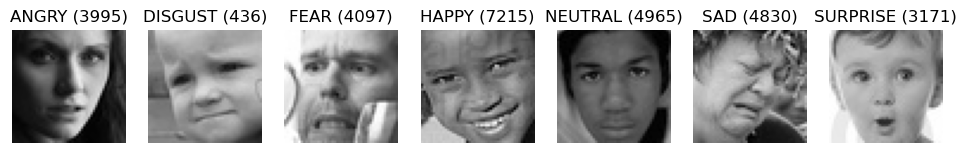

In [5]:
# setting values to rows and column variables
rows = 1
columns = 7
i = 1

# create figure
fig = plt.figure(figsize=(12, 9))


for emotion in Emotions:
    # class path - path to train dir + class name
    classPath   = train_dir + '/' + emotion
    
    # gets a random Image from each directory
    randomImage = random.choice(os.listdir(classPath))

    # Adds a subplot at the n position
    fig.add_subplot(rows, columns, i)
    # showing image
    plt.imshow(cv2.imread(classPath + '/' + randomImage))
    plt.axis('off')
    plt.title(emotion.upper() + " (" + str(Emotions[emotion]) + ")")

    i += 1

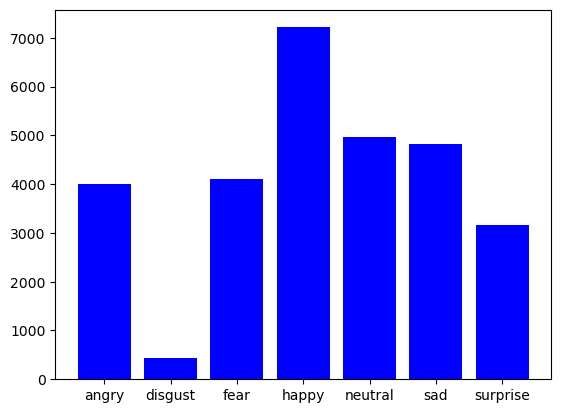

In [6]:
# create distribution plot about the number of images per class
for (emotion, count) in Emotions.items():
    plt.bar(emotion, count, color='blue')

(-1.1125279522049465,
 1.1169040515158202,
 -1.1082469107516235,
 1.1003927100357915)

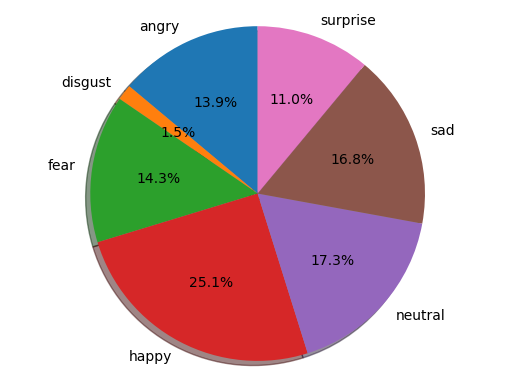

In [7]:
# create pie plot about the number of images per class
plt.pie(Emotions.values(), labels=Emotions.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

Loading Images...

Generates Some data using Data Augmentation for the disgust class

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    zoom_range=0.1
)

# create a folder name "AugImages" for the "Disgust" class in the "test" folder
# check if the folder exists
if not os.path.exists('../../Data/AugImages'):
    os.mkdir('../../Data/AugImages')

# iter the images from the folder "train/disgust"
for file in os.listdir('../../Data/AAUT2IA/train/disgust'):
    # load the image
    img = keras.utils.image_utils.load_img('../../Data/AAUT2IA/train/disgust/' + file, grayscale=True, target_size=(img_size, img_size))
    # convert the image to array
    x = keras.utils.image_utils.img_to_array(img)
    # reshape the image
    x = x.reshape((1,) + x.shape)

    # generate the augmented images
    num = 0
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='../../Data/AugImages/', save_prefix='aug',save_format='jpeg'):
        i += 1
        if i > 10:
            break  # Stop after generating 10 augmented images

    
# counts the number of images in the folder "AugImages"
print("Number of images in the folder \"AugImages\": ", len(os.listdir('../../Data/AugImages')))

# count the number of images in the folder "train/disgust"
print("Number of images in the folder \"train/disgust\": ", len(os.listdir('../../Data/AAUT2IA/train/disgust')))

d:\Conda\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


Number of images in the folder "AugImages":  3801
Number of images in the folder "train/disgust":  436


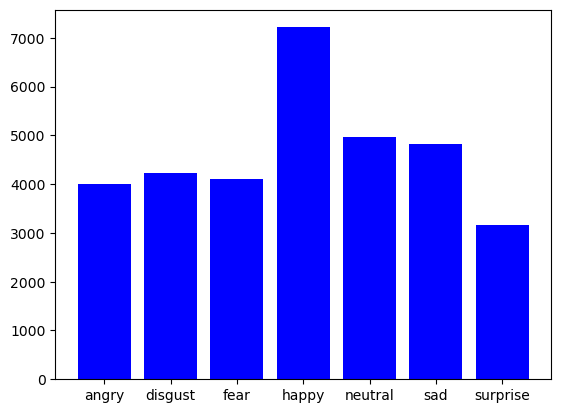

In [9]:
# Add to class disgust the number of images in the folder "AugImages"
Emotions['disgust'] = Emotions['disgust'] + len(os.listdir('../../Data/AugImages'))

# plots the distribution of the number of images per class in a bar plot
for (emotion, count) in Emotions.items():
    plt.bar(emotion, count, color='blue')


(-1.1028714720587873,
 1.103939042669825,
 -1.1131735196033736,
 1.1006273104573034)

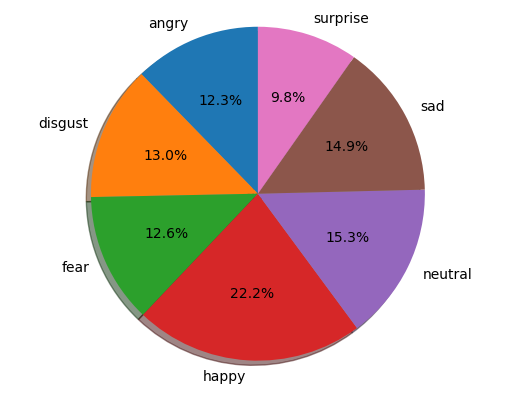

In [10]:
# create pie char about the number of images per class
plt.pie(Emotions.values(), labels=Emotions.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

## Model Blocks

* conv_block
* VGG16
* my_cnn_model
* model_block (resnet)

In [11]:
# Model Blocks for Deep Learning Models
def conv_block(input_layer, filters, kernel_size, strides, padding, activation, kernel_regularizer, name):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_regularizer=kernel_regularizer, name=name)(input_layer)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def vgg16_like(input_layer):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    
    return x

def my_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Block 2
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Block 3
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Block 4
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Block 5
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Block 6
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Flatten and fully-connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def model_block(x, filters, strides=1, activation='relu'):
    # Block of layers used twice in ResNet50
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

def FlattenLayer(x):
    # Flatten layer
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)

    return x

def resnet_block(x, filters, strides=1, activation='relu'):
    # Shortcut path
    shortcut = x
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    # Main path
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add shortcut and main path
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

## 1. Test Data

In [ ]:
epochs = 20
batch_size = 64

"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""

train_datagen = ImageDataGenerator(  # rotation_range = 180,
    width_shift_range   = 0.1,
    height_shift_range  = 0.1,
    horizontal_flip     = True,
    rescale             = 1./255,
    validation_split    = 0.2
)
validation_datagen = ImageDataGenerator(
    rescale             = 1./255,
    validation_split    = 0.2
)

"""
Applying data augmentation to the images as we read 
them from their respectivve directories
"""

train_generator = train_datagen.flow_from_directory(
    directory       = train_dir,
    target_size     = (img_size, img_size),
    batch_size      = batch_size,
    color_mode      = "grayscale",
    class_mode      = "categorical",
    subset          = "training"
)

validation_generator = validation_datagen.flow_from_directory(
    directory       = test_dir,
    target_size     = (img_size, img_size),
    batch_size      = batch_size,
    color_mode      = "grayscale",
    class_mode      = "categorical",
    subset          = "validation"
)


Testing to see if we use the same amount of data per class improves the final result

In [ ]:
# Input layer
input_layer = Input(shape=(img_size , img_size, 1))

# # Teste Model 1 - Acc +/- 0.55
# # Convolutional layers
# x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
# Residual blocks
# x = model_block(x, 64)

# Teste Model 2 - Acc +/- 26 - não aprendeu
# Residual blocks
# x = vgg16_like(input_layer)

# # Teste Model 3 - Acc +/- 58
# # Convolutional layers
# x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
# # Residual blocks

# x = model_block(x, 64)
# x = model_block(x, 64)

# x = model_block(x, 128, strides=2)
# x = model_block(x, 128)

# Teste Model 3 - Acc +/- 58
# Convolutional layers
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
# Residual blocks

x = model_block(x, 64)
x = model_block(x, 64)

x = model_block(x, 128, strides=2)
x = model_block(x, 128)

x = model_block(x, 256, strides=2)
x = model_block(x, 256)

# Flatten layer
x = FlattenLayer(x)

output_layer = Dense(7, activation='softmax')(x)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

model.summary()

# plot the model
# keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x               = train_generator,
    epochs          = epochs,
    validation_data = validation_generator
)

# save model
model.save('myModel.h5')

## 2. Test Data

In [ ]:
epochs = 20
batch_size = 64

train = tf.keras.utils.image_dataset_from_directory(
    directory   = train_dir,
    labels      = 'inferred',
    label_mode  = 'int',
    color_mode  = 'grayscale',
    batch_size  = batch_size,
    image_size  = (img_size, img_size),
    shuffle     = True,
    seed        = 10
)

test = tf.keras.utils.image_dataset_from_directory(
    directory   = test_dir,
    labels      = 'inferred',
    label_mode  = 'int',
    color_mode  = 'grayscale',
    batch_size  = batch_size,
    image_size  = (img_size, img_size),
    shuffle     = True,
    seed        = 10
)


In [ ]:
class_names = train.class_names
print("Classes: ", class_names)

In [ ]:
plt.figure(figsize=(6, 6))

for images, labels in train.take(1):
    for i in range(15):
        # Adds a subplot at the n position
        ax = plt.subplot(3, 5, i+1)
        # showing image
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.axis('off')
        plt.title(class_names[labels[i]].upper())

plt.show()

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=42),	
    tf.keras.layers.RandomRotation(0.1),
    # tf.keras.layers.Rescaling(1./255)
    # normalize the data
    #tf.keras.layers.
])

plt.figure(figsize=(6, 6))

for images, labels in train.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images[i])
        # Adds a subplot at the n position
        ax = plt.subplot(3, 5, i+1)
        # showing image
        plt.imshow(augmented_images.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')
        plt.title(class_names[labels[i]].upper())

plt.show()

In [ ]:
train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# train = train.map(lambda x, y: (data_augmentation(x, training=True), tf.one_hot(y, 7)))
train = train.map(lambda x, y: (x / 255.0, tf.one_hot(y, 7)))
# train = train.repeat()

Model

In [ ]:
# Input layer
input_layer = Input(shape=(img_size , img_size, 1))

# Teste Model 1 - Acc +/- 0.55
# Convolutional layers
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

# Residual blocks
x = model_block(x, 64)

# Flatten layer
x = FlattenLayer(x)

output_layer = Dense(7, activation='softmax')(x)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

# Define optimizer and compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),#learning_rate=0.02),
    metrics=['accuracy']
)

# Train model
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

model.summary()

# plot the model
# keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit model
# history = model.fit(train, validation_data = test, epochs=epochs, callbacks=[callback])
history = model.fit(train, validation_data = test, epochs=epochs, callbacks=[callback], steps_per_epoch=200, validation_steps=100)

# save model
model.save('myModel.h5')

## 3. Test Model

In [12]:
# Disgut class was removed from one dataset "AAUT2IA_Test"
# we will nevel use this to test the model
# remove extra files from the dataset

train_dir_teste = "../../Data/AAUT2IA_Teste/train"
test_dir_teste =  "../../Data/AAUT2IA_Teste/test"

# counts whit of the subfolders from train_dir contains the least amount of files
min_count = 0
for folder in os.listdir(train_dir_teste):
    count = len(os.listdir(os.path.join(train_dir_teste, folder)))
    if min_count == 0:
        min_count = count
    elif count < min_count:
        min_count = count

print("Min count: ", min_count)

# removes a random number of files from each subfolder from train_dir to match the min_count
for folder in os.listdir(train_dir_teste):
    files = os.listdir(os.path.join(train_dir_teste, folder))
    random.shuffle(files)
    for file in files[min_count:]:
        os.remove(os.path.join(train_dir_teste, folder, file))

# plot pie chart with the number of files in each subfolder
labels = []
sizes = []
for folder in os.listdir(train_dir_teste):
    count = len(os.listdir(os.path.join(train_dir_teste, folder)))
    labels.append(folder)
    sizes.append(count)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

FileNotFoundError: [WinError 3] O sistema não conseguiu localizar o caminho especificado: '../../Data/AAUT2IA_Teste/train'

In [13]:
# Define some hyperparameters
img_height = img_width = img_size = 128
batch_size = 32
epochs = 50

# we will be using this for testing
# train_dir_teste = "../../Data/AAUT2IA_Teste/train"
# test_dir_teste =  "../../Data/AAUT2IA_Teste/test"

# Load the dataset using image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    # directory=train_dir_teste,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=10
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    # directory=test_dir_teste,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=10
)

# rescaling the data and applying data augmentation
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomContrast(0.1)
  ]
)

# Calculate the number of classes in the dataset
num_classes = 7

# resclaing the data and data augmentation
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
test_ds  = test_ds.map(lambda x, y: (x / 255.0, y))

# Build a more complex CNN model

# Input layer
input_layer = Input(shape=(img_size , img_size, 1))

# Convolutional layers
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Residual blocks
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=64)

x = Dropout(0.3)(x)

x = resnet_block(x, filters=128, strides=2)
x = resnet_block(x, filters=128)
x = resnet_block(x, filters=128)
x = resnet_block(x, filters=128)

x = Dropout(0.3)(x)

x = resnet_block(x, filters=256, strides=2)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)

x = Dropout(0.3)(x)

x = resnet_block(x, filters=512, strides=2)
x = resnet_block(x, filters=512)
x = resnet_block(x, filters=512)

x = Dropout(0.3)(x)

# Flatten the output
x = Flatten()(x)

# Dense layers
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

# Output layer
output_layer = Dense(num_classes, activation='softmax')(x)

# define the model
model = Model(input_layer, output_layer)

model.summary()

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model on the dataset
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds
)

model.save('myModel.h5')

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_n

KeyboardInterrupt: 

In [ ]:
# Tests

# Build a CNN model
# model = tf.keras.Sequential([

#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')
# ]) 

# Info : [AccTrain-90%] | [AccTest-50%] | [LossTrain-0.3] | [LossTest-1.5]


# Build a more complex CNN model
# model = keras.Sequential([
#     keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 1)),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(128, 3, activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(256, 3, activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])
# Info : [AccTrain-55%] | [AccTest-55%]

# model = keras.Sequential([
#     # Convolutional layers
#     keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 1)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(32, 3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(32, 5, strides=2, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.4),

#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.4),

#     keras.layers.Conv2D(128, 4, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.4),

#     keras.layers.Conv2D(256, 4, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.4),

#     # Fully connected layers
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.4),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])
# Info : [AccTrain-87%] | [AccTest-57%]


# Build a more complex CNN model
# model = keras.Sequential([
#     # Convolutional layers
#     keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 1)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(32, 3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(32, 5, strides=2, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.3),

#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.3),

#     keras.layers.Conv2D(128, 4, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(128, 4, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(128, 6, strides=2, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),

#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.4),

#     # Fully connected layers
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.4),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])
# Info : [AccTrain-77%] | [AccTest-60%]


## Model Evaluating

In [ ]:
# plot model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# evaluate model
_, acc = model.evaluate(test_ds, verbose=0)
print('> %.3f' % (acc * 100.0))

In [ ]:
# create confusion matrix
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

# plot confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# create classification report
print('Classification Report')
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))